In [146]:
import copy
import numpy as np
import matplotlib.pyplot as p
import astropy.units as u
import funcs
import emcee
import corner

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
lc = np.genfromtxt('Lightcurves/kplr008180020_llc_f.txt')
time = lc[:,0]+2454833.
flux = lc[:,1]
err = lc[:,2]
print(time[0])

2455185.39735


In [172]:
# KIC008180020
pp = 279.284861
pb = 5.8031267986
ap = ((pp/365.25)**2 * (0.9+0.3588) )**(1./3.)
ab = ((pb/365.25)**2 * (0.9+0.3588) )**(1./3.)

cb = funcs.CBSystem(m1 = 0.9,f1 = 1.,m2 = 0.3588,f2 = 0.003058,
                    ab = ab,r1 = 0.08868776*ab,r2 = 0.01989460*ab,
                    eb = 0.0164,ib = np.deg2rad(89.50),wb = 0.73,
                    fb = 2.54075,
                    mp = 1.0 * u.Mjup.to('Msun'),ap = ap,rp = 1.0 * u.Rjupiter.to('au'),
                    ep = 0.184,
                    ip = np.deg2rad(90.300),wp = np.deg2rad(30.1),fp = 4.0066,
                    Wp = np.deg2rad(-0.17),
                    t0 = 2455185.39735)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days

print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
t = time

5.8031267986
279.284861


In [141]:
f_pl = funcs.pd_cb(cb, times=t)
tmp = cb.rp
cb.rp = 0.0
f_nopl = funcs.pd_cb(cb, times=t)
cb.rp = tmp
f_ref = f_pl / f_nopl

<IPython.core.display.Javascript object>


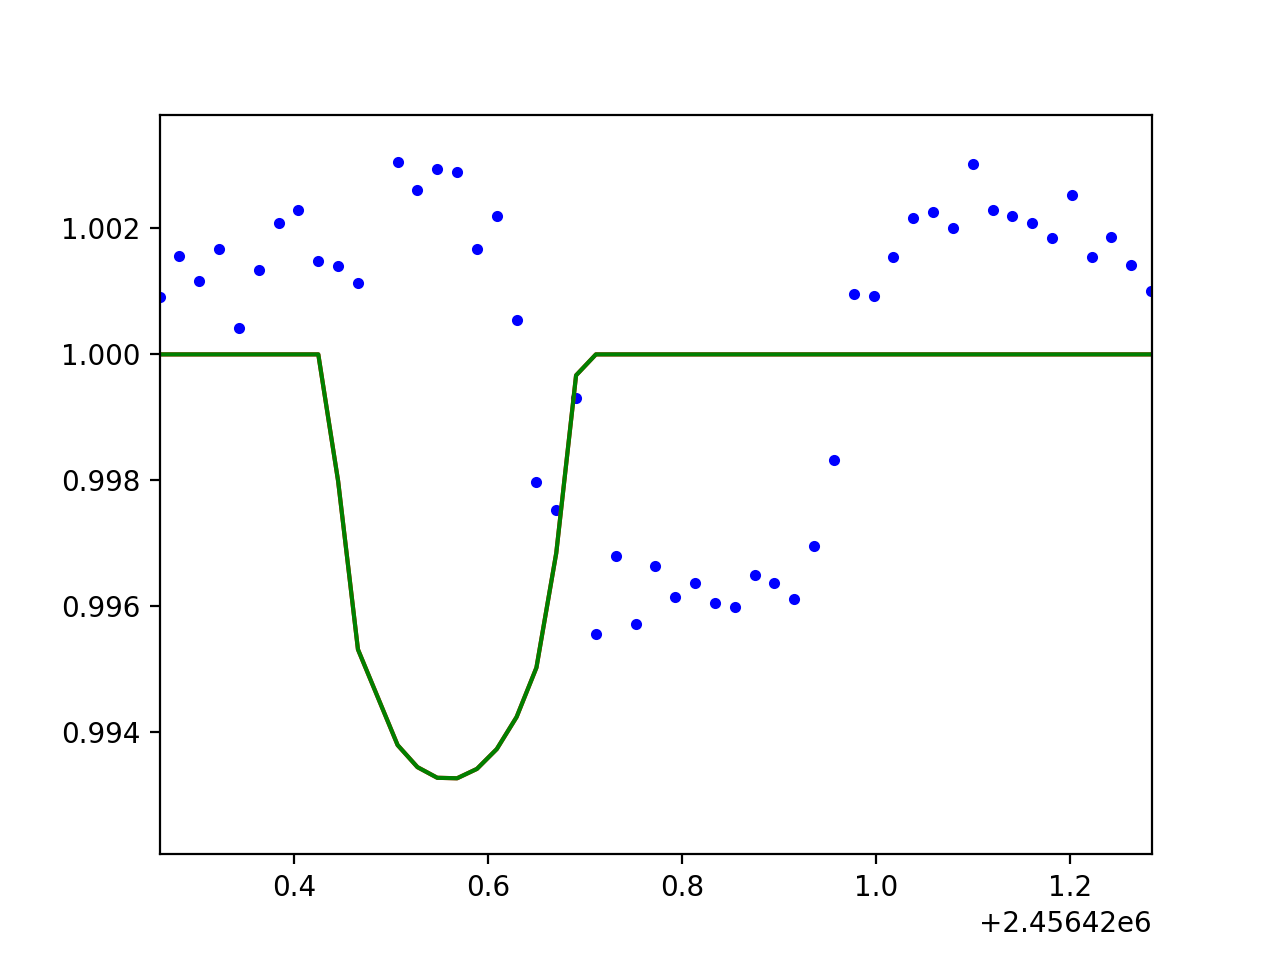

In [142]:
p.figure()
p.plot(time,flux,'b.')
p.plot(t,f_pl,'r-')
p.plot(t,f_ref,'g-')

In [173]:
#reference transit times (by eye)
ref_tts = np.array([472.245,751.125,1029.995,1308.910,1587.795])
ref_tts+=2454833.
ref_tds = np.array([0.29,0.31,0.33,0.34,0.35])
tts,tds = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
print(tts[tds>0])
print(tts[tds>0]-ref_tts)

[ 2455305.85839421  2455584.52871955  2455863.2016356   2456141.8788695
  2456420.56171661]
[ 0.61339421  0.40371955  0.2066356  -0.0311305  -0.23328339]


In [175]:
# log likelihood function, based on timing
def lnlike(par, *args):
    cb, t = args
    #cb.m1, cb.m2, cb.eb, cb.wb, cb.ap, cb.fp, cb.Wp = par
    #totalmass, massratio, p_p, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp = par
    #totalmass, massratio, 
    p_p, cb.eb, cb.wb, cb.ib, cb.fp, cb.ip, cb.Wp, cb.ep, cb.wp = par
    #cb.m2 = totalmass / (1 + 1./massratio)
    #cb.m1 = totalmass / (1 + massratio)
    #cb.ap = ( totalmass * (p_p/365.25)**2 )**(1./3.)
    cb.ap = ( (cb.m1+cb.m2) * (p_p/365.25)**2 )**(1./3.)
    
    # force binary period to be fixed
    #cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.)

    try:
        #tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
        #tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
        tts,tds = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
        tts = tts[tds>0]
    except:
        return -np.inf

    #ok = tts[:,0] == 20 #primary transits only
    #if np.sum(ok) != len(ref_tts):
    #    return -np.inf
    if len(tts) != len(ref_tts):
        return -np.inf

    # metric based on 1sigma being some fraction of a day/transit
    #dts = tts[ok,1] - ref_tts[:,1]
    dts = tts - ref_tts
    diff = np.sum( (np.abs(dts)/0.02)**2 )
    #print(dts,-0.5*diff)

    return -0.5 * diff

In [ ]:
# run emcee to see where we go
nwalkers = 32

#par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp]
#labels = ['m1+m2','m2/m1','p_p','eb','wb','fp','ip','Wp']
#par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.eb, cb.wb, cb.ib, cb.fp, cb.ip, cb.Wp, cb.ep, cb.wp] #N.B ep limited to <0.05 - some constraint
#labels = ['m1+m2','m2/m1','p_p','eb','wb','ib','fp','ip','Wp', 'ep', 'wp']
#par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.ib, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp]
#labels = ['m1+m2','m2/m1','p_p','ib','eb','wb','fp','ip','Wp']
par0 = [p_p0, cb.eb, cb.wb, cb.ib, cb.fp, cb.ip, cb.Wp, cb.ep, cb.wp] #N.B ep limited to <0.05 - some constraint
labels = ['p_p','eb','wb','ib','fp','ip','Wp', 'ep', 'wp']

npar = len(par0)
par0 = [ par0 + par0*np.random.normal(scale=0.001,size=npar) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, npar, lnlike, args=(copy.deepcopy(cb), t), threads=4 )
pos,lnprob,rstate = sampler.run_mcmc(par0, 3000)

/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


<IPython.core.display.Javascript object>


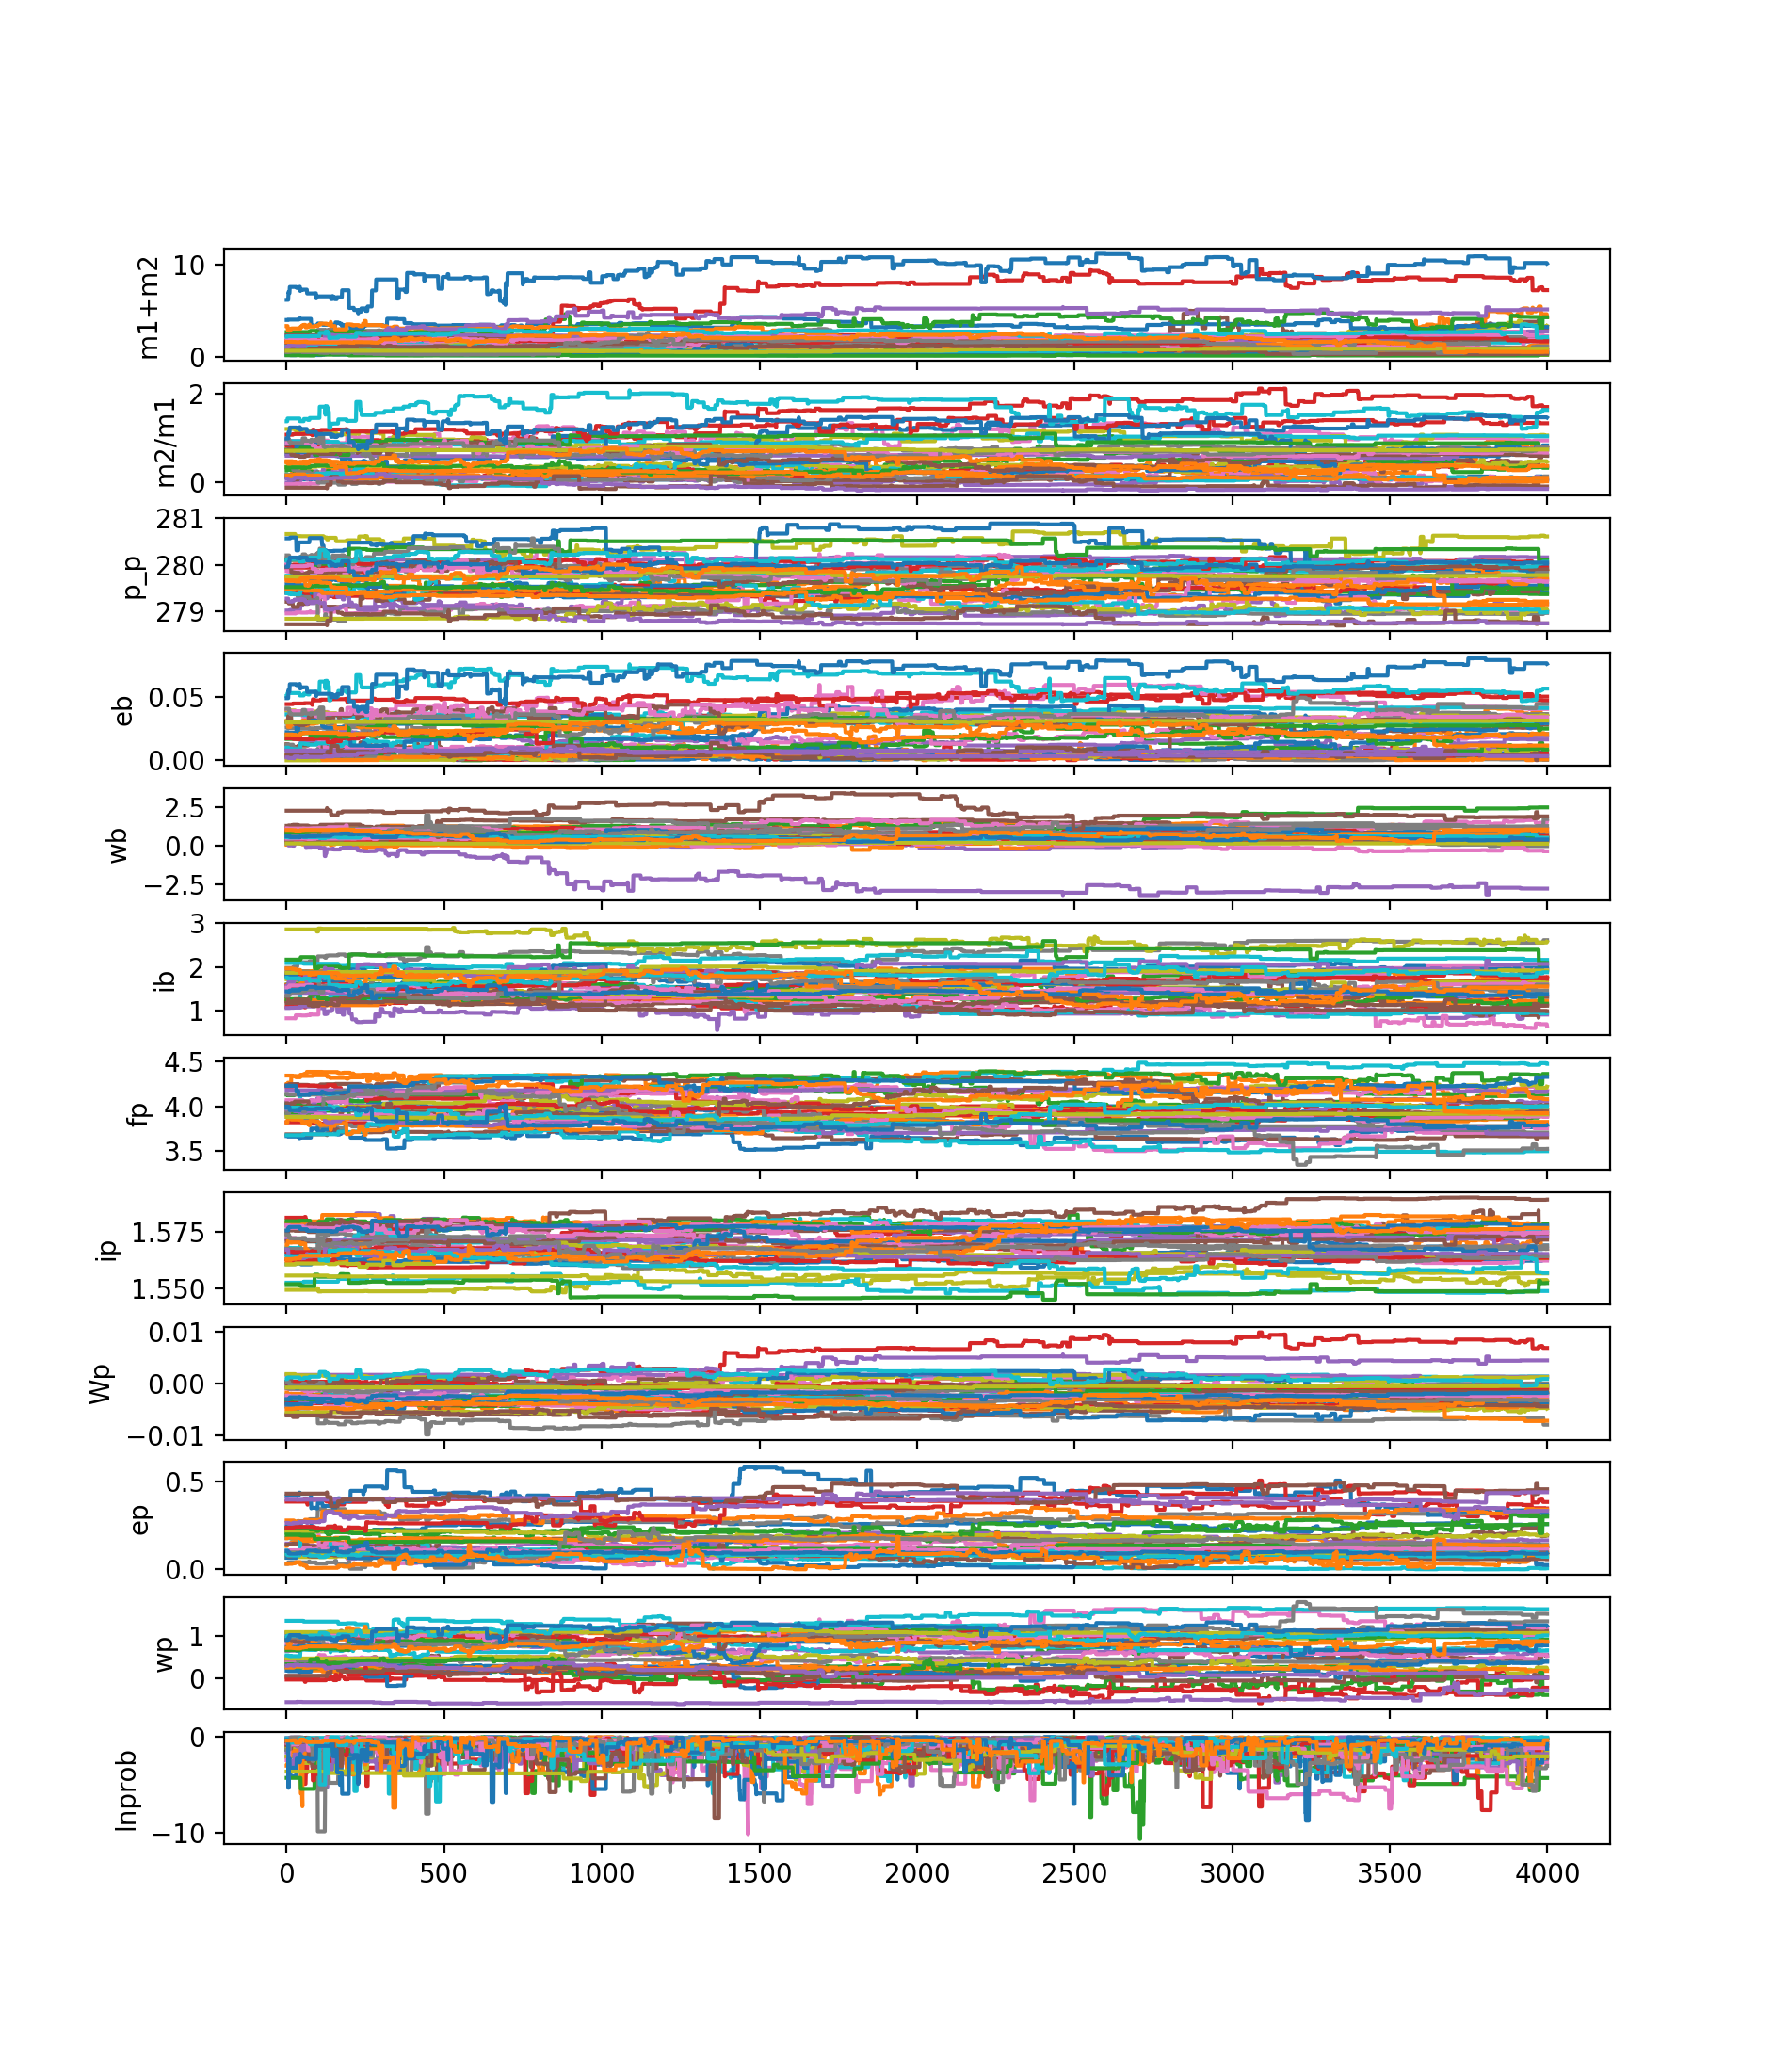

In [161]:
burn_in = 1000
fig,ax = p.subplots(npar+1,figsize=(9.5,npar),sharex=True)
for j in range(nwalkers):
    ax[npar].plot(sampler.lnprobability[j,burn_in:])
    ax[npar].set_ylabel('lnprob')
    for i in range(npar):
        ax[i].plot(sampler.chain[j,burn_in:,i])
        ax[i].set_ylabel(labels[i])

<IPython.core.display.Javascript object>


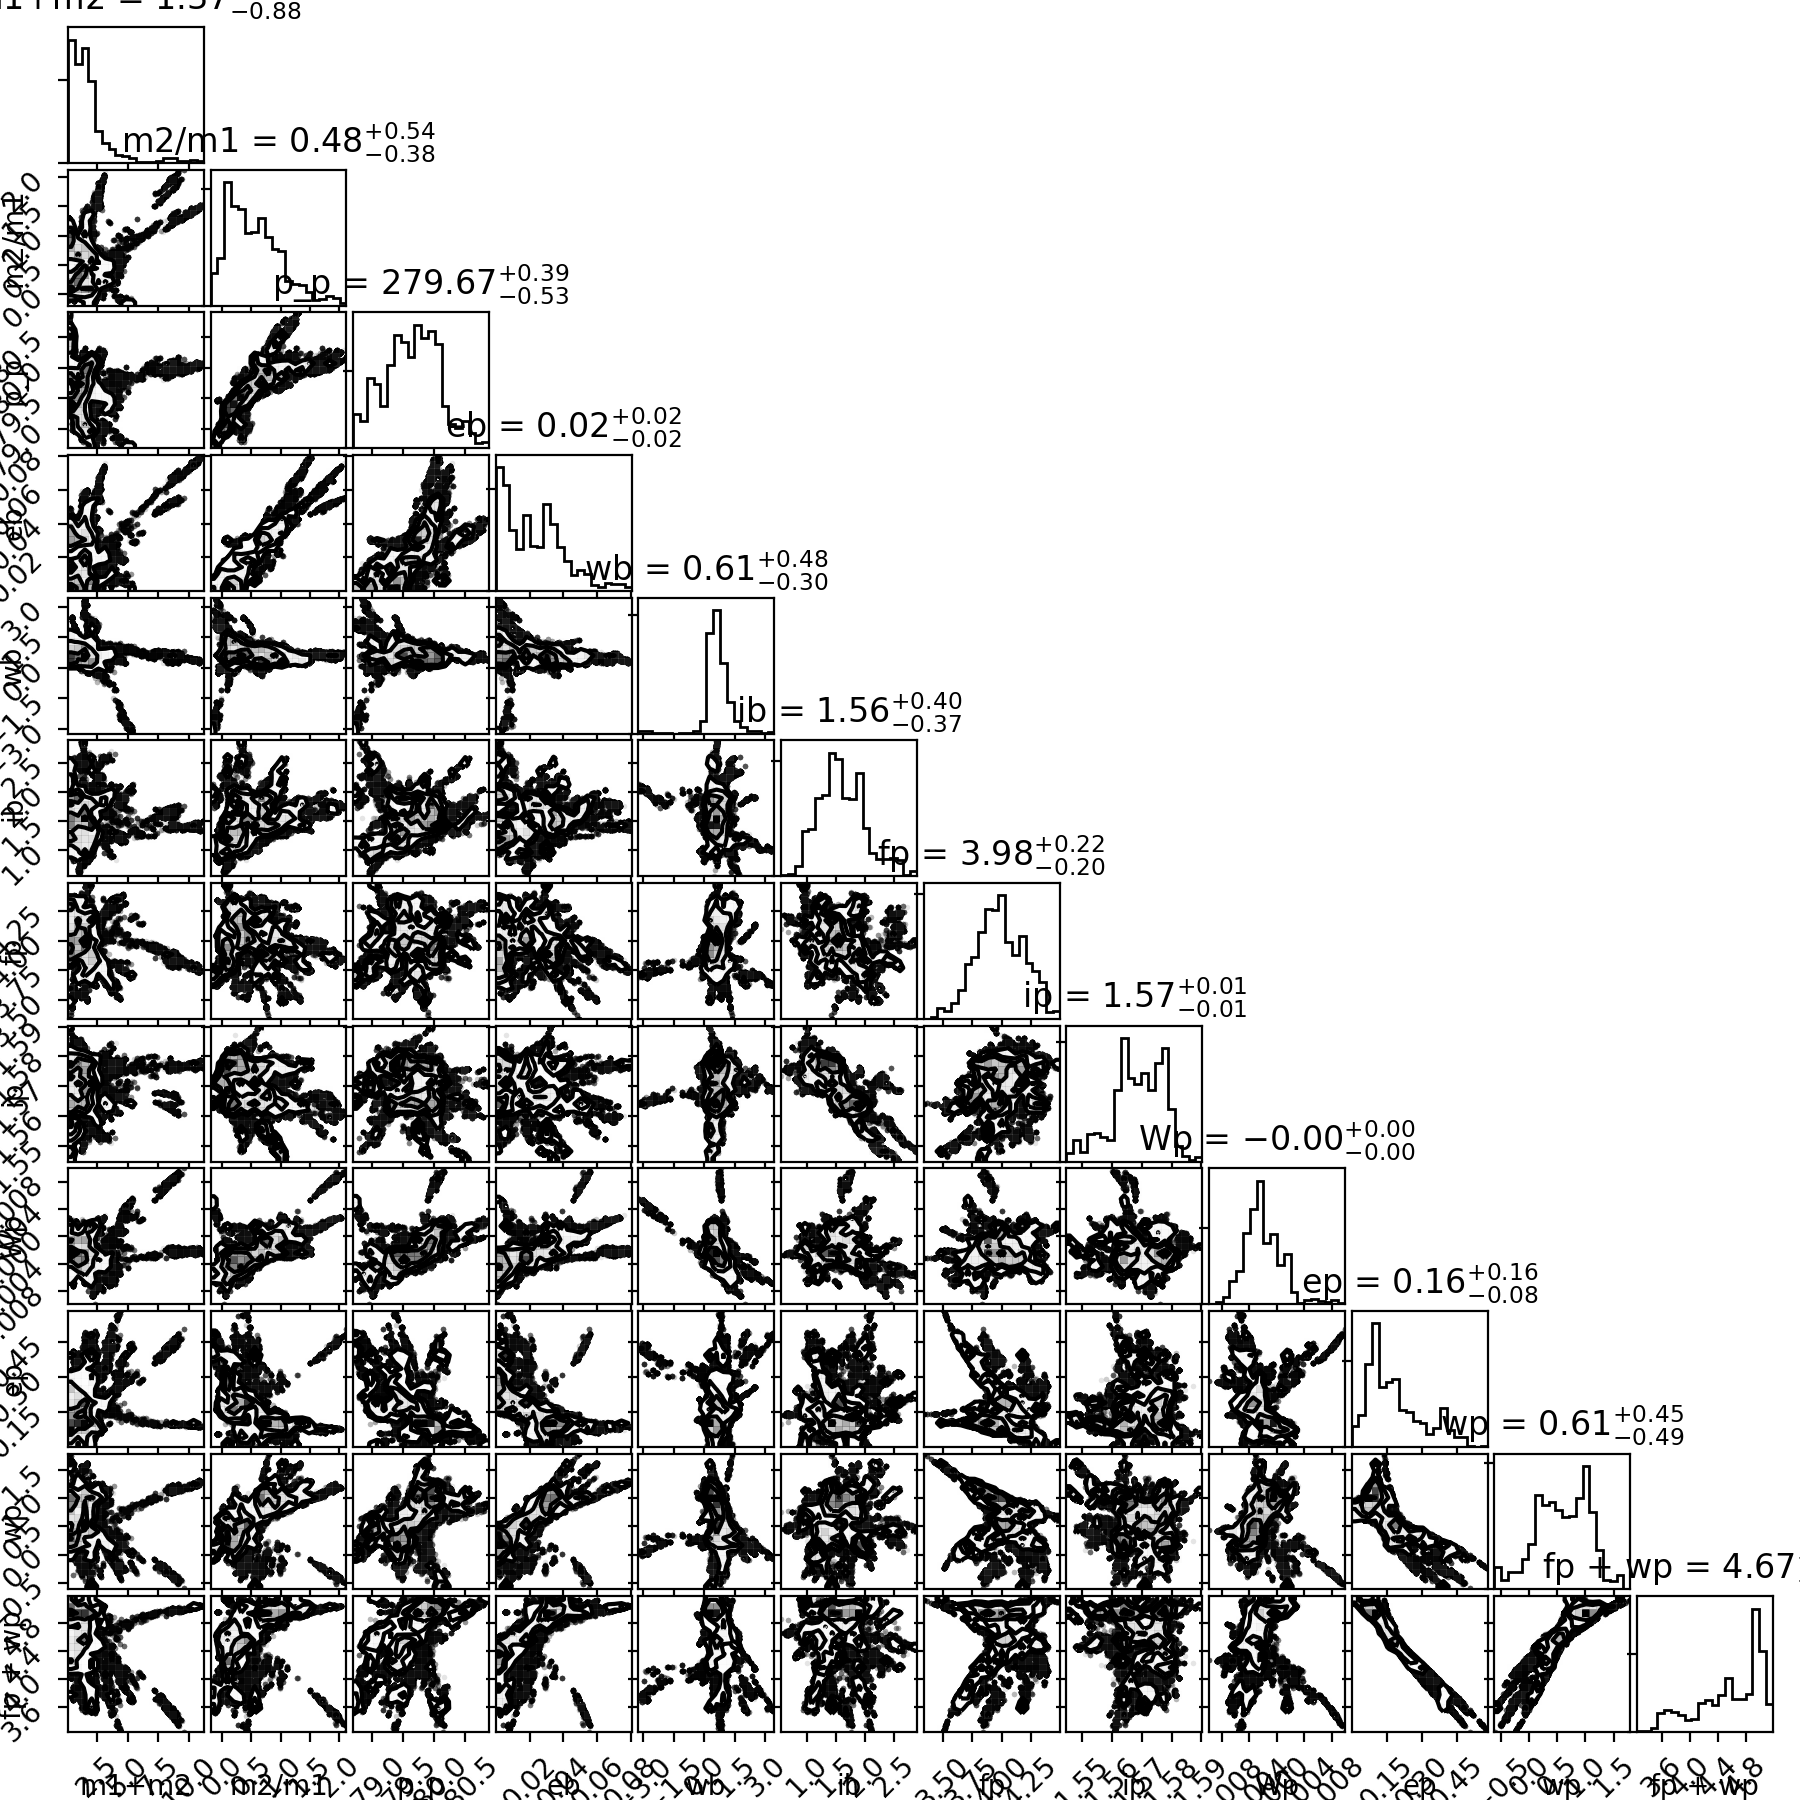

In [163]:
chains = sampler.flatchain[burn_in:]
chains = np.vstack((chains.T,np.mod(chains[:,6]+chains[:,10],2*np.pi))).T
labels += ['fp + wp']
#labels = labels[:-1]
fig,ax = p.subplots(npar+1,npar+1,figsize=(9,9))
fig = corner.corner(chains,labels=labels,fig=fig,show_titles=True)

<IPython.core.display.Javascript object>


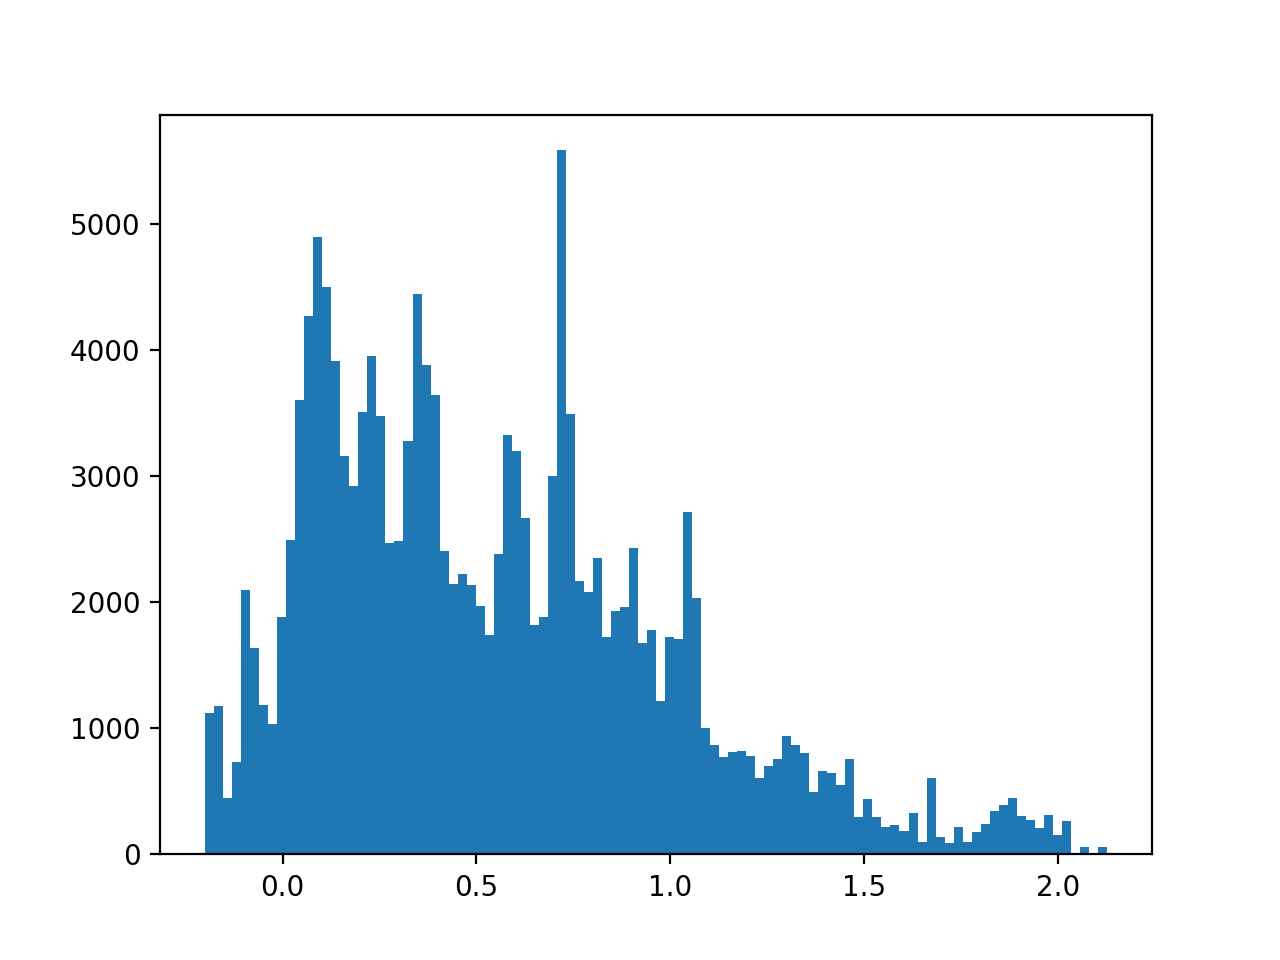

0.707268358088


In [168]:
p.figure()
p.hist(chains[:,1],bins=100)
hist,bins = np.histogram(chains[:,1],bins=100)
print(bins[np.argmax(hist)])

In [169]:
hist,bins = np.histogram(chains[:,0],bins=100)
totalmass = bins[np.argmax(hist)]
massratio = 0.48
p_p = 279.67
cb.eb = 0.02
cb.wb = 0.61
cb.ib=1.56
cb.fp=3.98
cb.ip=1.57
cb.Wp = 0.
cb.ep = 0.16
cb.wp = 0.61

cb.m2 = totalmass / (1 + 1./massratio)
cb.m1 = totalmass / (1 + massratio)
cb.ap = ( totalmass * (p_p/365.25)**2 )**(1./3.)
    
# force binary period to be fixed
cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.)


In [170]:
f_pl = funcs.pd_cb(cb, times=t)
tmp = cb.rp
cb.rp = 0.0
f_nopl = funcs.pd_cb(cb, times=t)
cb.rp = tmp
f_ref = f_pl / f_nopl

<IPython.core.display.Javascript object>


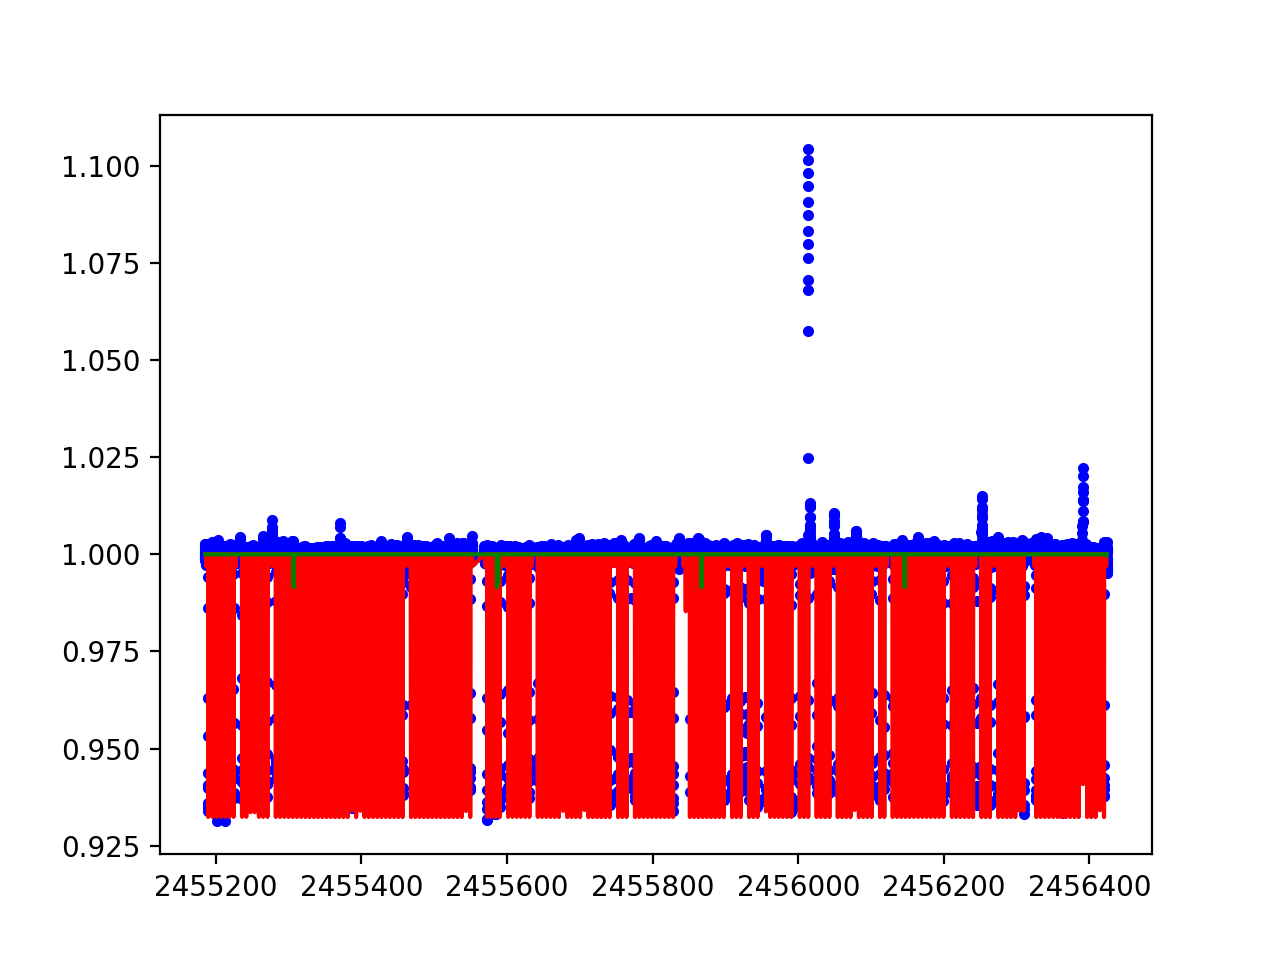

In [171]:
p.figure()
p.plot(time,flux,'b.')
p.plot(t,f_pl,'r-')
p.plot(t,f_ref,'g-')

In [157]:
#reference transit times (by eye)
ref_tts = np.array([472.245,751.125,1029.995,1308.910,1587.795])
ref_tts+=2454833.
ref_tds = np.array([0.29,0.31,0.33,0.34,0.35])
tts,tds = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
print(tts[tds>0])
print(tts[tds>0]-ref_tts)

[ 2455305.85839421  2455584.52871955  2455863.2016356   2456141.8788695
  2456420.56171661]
[ 0.61339421  0.40371955  0.2066356  -0.0311305  -0.23328339]
